In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the data 

In [2]:
# Define data path
data_path = "data/waiting times"

# Read in all waiting time CSV files
df_list = []
for filename in os.listdir(data_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_path, filename)
        attraction_name = filename.replace(".csv", "")
        df = pd.read_csv(filepath)
        df["attraction"] = attraction_name
        df_list.append(df)

# Combine all dataframes
all_waiting_times = pd.concat(df_list, ignore_index=True)
print(f"Total number of records: {len(all_waiting_times)}")
all_waiting_times.info()


Total number of records: 10306140
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10306140 entries, 0 to 10306139
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   datetime    object 
 2   SACTMIN     float64
 3   SPOSTMIN    float64
 4   attraction  object 
dtypes: float64(2), object(3)
memory usage: 393.1+ MB


C:\Users\Guti\AppData\Local\Temp\ipykernel_5064\953059848.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_waiting_times = pd.concat(df_list, ignore_index=True)


In [3]:
# Clean the data
df_wait_raw = all_waiting_times.copy()

# Remove outliers in the Actual waiting time
df_wait = df_wait_raw[
    ((df_wait_raw["SACTMIN"] >= -1000) & (df_wait_raw["SACTMIN"] < 360))
    | (df_wait_raw["SACTMIN"].isnull())
]

# Remove -999 values in the Posted waiting time (closed attraction)
df_wait = df_wait[(df_wait["SPOSTMIN"] >= -998.99) | (df_wait["SPOSTMIN"].isnull())]

# Convert date and time columns to datetime format
df_wait["date"] = pd.to_datetime(df_wait["date"], errors="coerce", format="%m/%d/%Y")
df_wait["datetime"] = pd.to_datetime(
    df_wait["datetime"], errors="coerce", format="%Y-%m-%d %H:%M:%S"
)

# Remove duplicates
df_wait = df_wait.drop_duplicates()
print(f"Final number of records after cleaning: {len(df_wait)}")


Final number of records after cleaning: 8987437


## 2. Building the model

In [4]:
# Step 1: Take a sample from the large dataset
# For a dataset with 8.9M rows, a sample of around 100,000 rows should be sufficient for initial modeling
sample_size = 100000
df_sample = df_wait.sample(n=sample_size, random_state=42)
print(f"Sample size: {len(df_sample)}")

# Check if the sample is representative
print("\nSample statistics:")
print(df_sample[["SACTMIN", "SPOSTMIN"]].describe())
print("\nOriginal dataset statistics:")
print(df_wait[["SACTMIN", "SPOSTMIN"]].describe())


Sample size: 100000

Sample statistics:
           SACTMIN      SPOSTMIN
count  2225.000000  97775.000000
mean     21.662022     35.297919
std      19.775310     30.289541
min       0.000000      0.000000
25%       8.000000     10.000000
50%      16.000000     30.000000
75%      29.000000     50.000000
max     204.000000    330.000000

Original dataset statistics:
             SACTMIN      SPOSTMIN
count  192372.000000  8.795065e+06
mean       21.526568  3.521797e+01
std        19.224254  3.020612e+01
min         0.000000  0.000000e+00
25%         8.000000  1.000000e+01
50%        17.000000  3.000000e+01
75%        29.000000  5.000000e+01
max       329.000000  3.900000e+02


Now, let's prepare the data for modeling by extracting relevant features:

In [5]:
# Step 2: Feature engineering
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract time-based features
df_sample["hour"] = df_sample["datetime"].dt.hour
df_sample["day_of_week"] = df_sample["datetime"].dt.dayofweek
df_sample["month"] = df_sample["datetime"].dt.month
df_sample["is_weekend"] = df_sample["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
df_sample["year"] = df_sample["datetime"].dt.year

# Encode categorical variables
df_sample = pd.get_dummies(df_sample, columns=["attraction"], drop_first=True)

# Drop rows with NaN in the target variable (SACTMIN)
df_model = df_sample.dropna(subset=["SACTMIN"])
print(f"Rows after dropping NaN in target: {len(df_model)}")

# Define features and target
# We'll predict SACTMIN (actual waiting time) using SPOSTMIN (posted waiting time) and other features
features = ["SPOSTMIN", "hour", "day_of_week", "month", "is_weekend", "year"] + [
    col for col in df_model.columns if col.startswith("attraction_")
]
X = df_model[features].copy()
y = df_model["SACTMIN"]

# Handle any remaining NaN values in features (like SPOSTMIN)
X.fillna(-1, inplace=True)  # Replace NaN with -1 (as a flag value)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")


Rows after dropping NaN in target: 2225
Training set size: 1780, Test set size: 445


Now, let's train the Random Forest model:

Random Forest Model Evaluation:
Mean Absolute Error: 11.22 minutes
Root Mean Squared Error: 15.45 minutes
R-squared: 0.4030


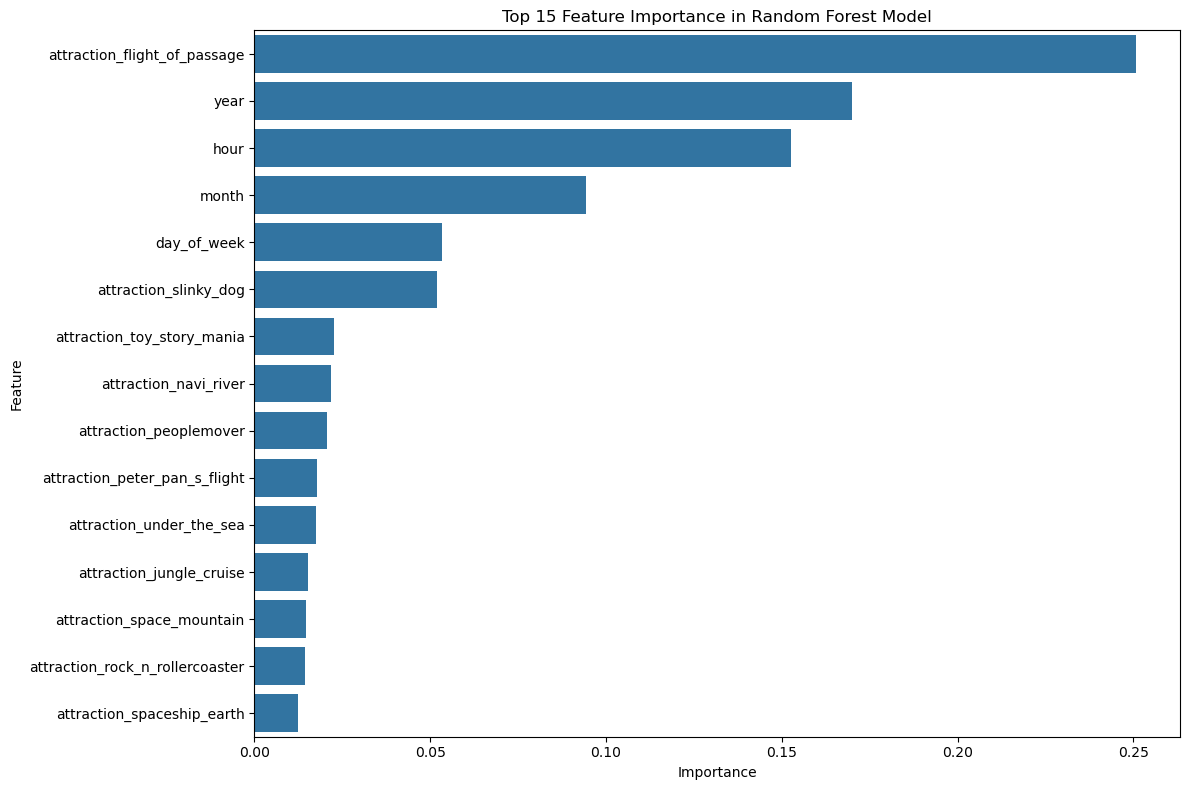

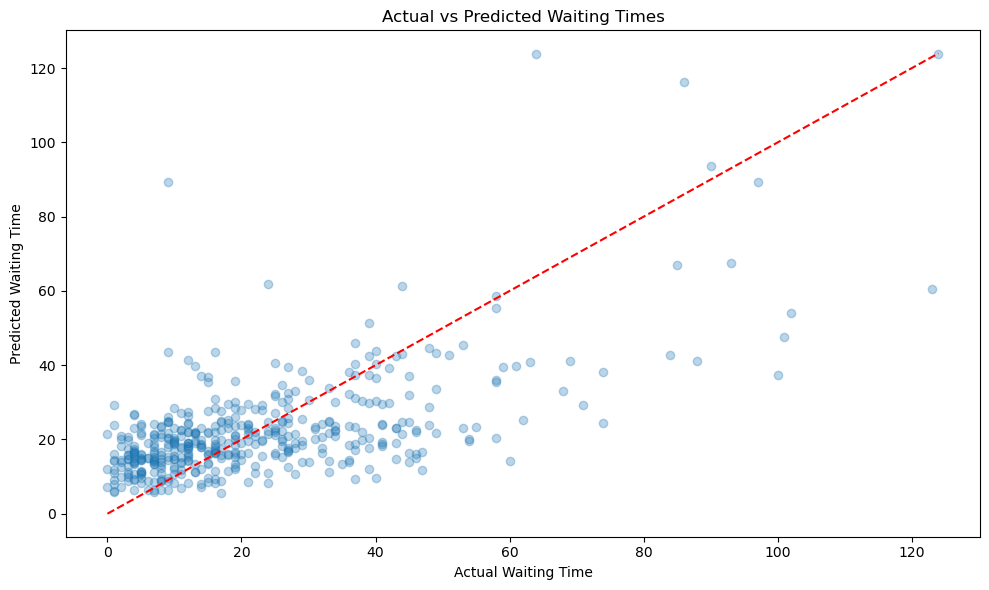

In [6]:
# Step 3: Train a Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model Evaluation:")
print(f"Mean Absolute Error: {mae:.2f} minutes")
print(f"Root Mean Squared Error: {rmse:.2f} minutes")
print(f"R-squared: {r2:.4f}")

# Plot feature importance
feature_importance = pd.DataFrame(
    {"Feature": features, "Importance": rf_model.feature_importances_}
).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(15))
plt.title("Top 15 Feature Importance in Random Forest Model")
plt.tight_layout()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Waiting Time")
plt.ylabel("Predicted Waiting Time")
plt.title("Actual vs Predicted Waiting Times")
plt.tight_layout()
plt.show()


Now, let's try some alternative models that might perform better:

Training ElasticNet...
ElasticNet - CV RMSE: 18.16, Test RMSE: 18.06
Training Gradient Boosting...
Gradient Boosting - CV RMSE: 15.77, Test RMSE: 15.03
Training XGBoost...
XGBoost - CV RMSE: 15.77, Test RMSE: 15.22
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99
[LightGBM] [Info] Number of data points in the train set: 1483, number of used features: 30
[LightGBM] [Info] Start training from score 22.241403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

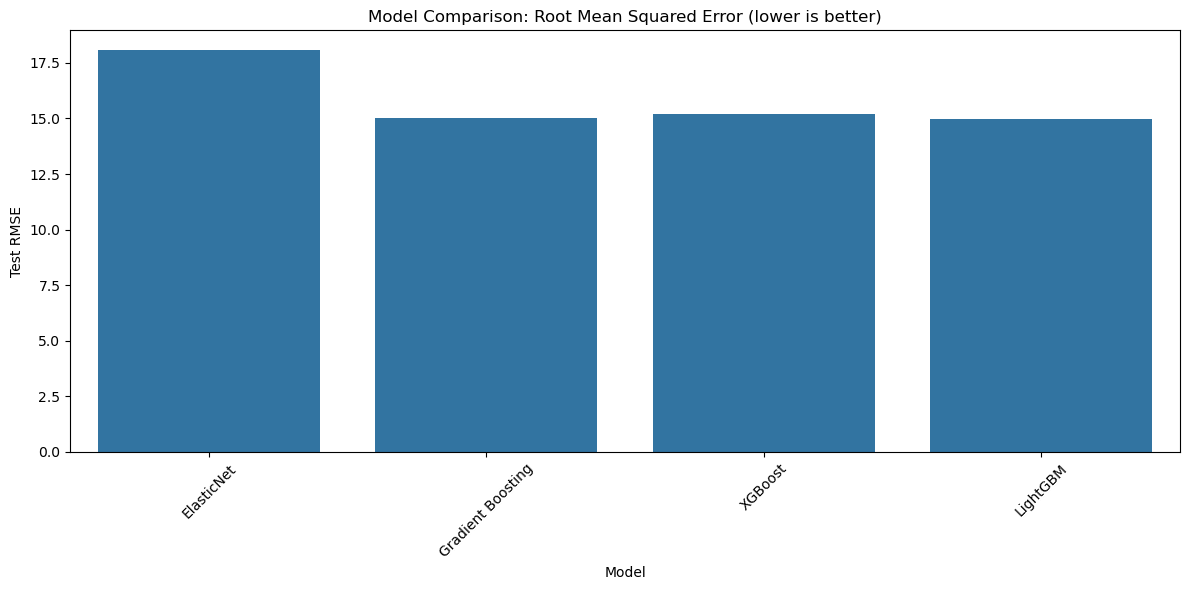

In [9]:
# Step 4: Alternative models
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score


# Function to evaluate model
def evaluate_model(model, X, y, cv=5):
    # Cross-validation
    cv_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_root_mean_squared_error"
    )
    cv_rmse = -cv_scores.mean()

    # Train the model on the entire dataset
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "CV RMSE": cv_rmse,
        "Test MAE": mae,
        "Test RMSE": rmse,
        "Test R²": r2,
        "Predictions": y_pred,
    }


# Models to evaluate
models = {
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
    ),
}

# Evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = evaluate_model(model, X, y, cv=3)  # Using 3-fold CV to save time
    print(
        f"{name} - CV RMSE: {results[name]['CV RMSE']:.2f}, Test RMSE: {results[name]['Test RMSE']:.2f}"
    )

# Compare model performance
comparison = pd.DataFrame(
    {
        "Model": list(results.keys()),
        "CV RMSE": [results[model]["CV RMSE"] for model in results],
        "Test MAE": [results[model]["Test MAE"] for model in results],
        "Test RMSE": [results[model]["Test RMSE"] for model in results],
        "Test R²": [results[model]["Test R²"] for model in results],
    }
)

print("\nModel Comparison:")
print(comparison.sort_values("Test RMSE"))

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Test RMSE", data=comparison)
plt.title("Model Comparison: Root Mean Squared Error (lower is better)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


For time series forecasting, let's also consider a time-series specific approach:

Time series analysis for attraction: buzz_lightyear
Number of records: 304457


C:\Users\Guti\AppData\Local\Temp\ipykernel_5064\1405655264.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = ts_data["SACTMIN"].resample("H").mean()
C:\Users\Guti\AppData\Local\Temp\ipykernel_5064\1405655264.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hourly_data = hourly_data.fillna(method="ffill").fillna(method="bfill")


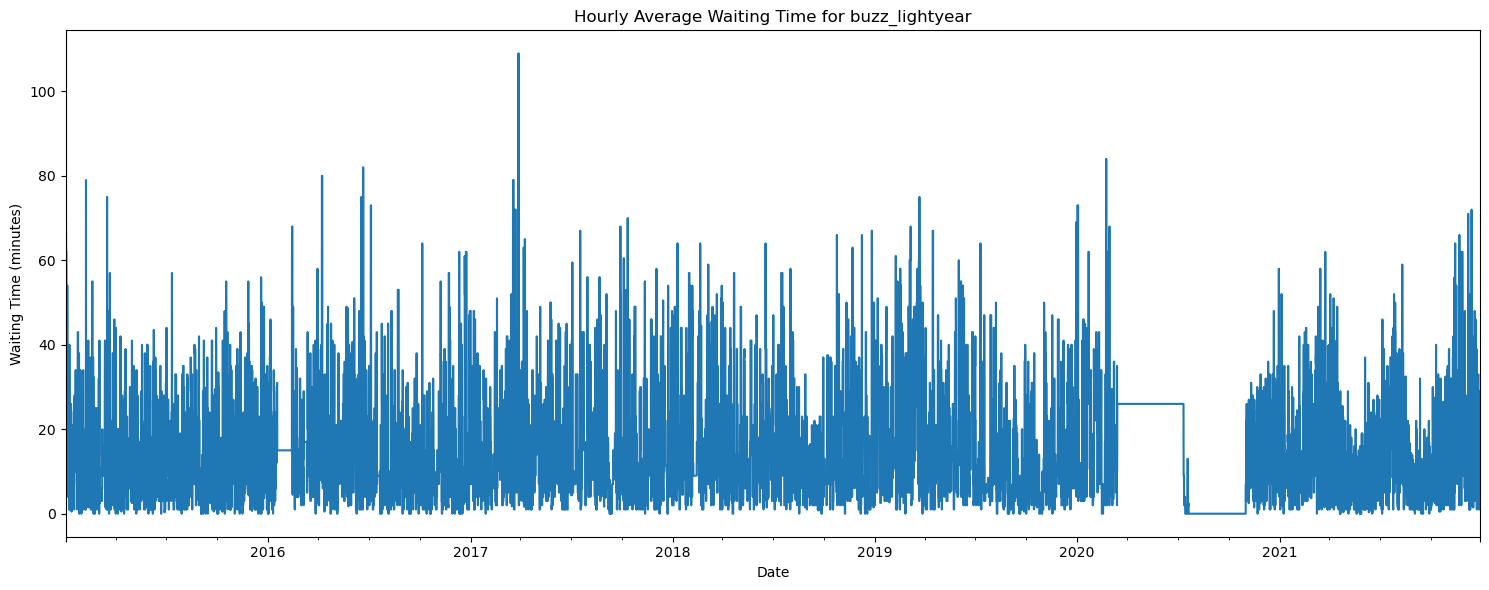

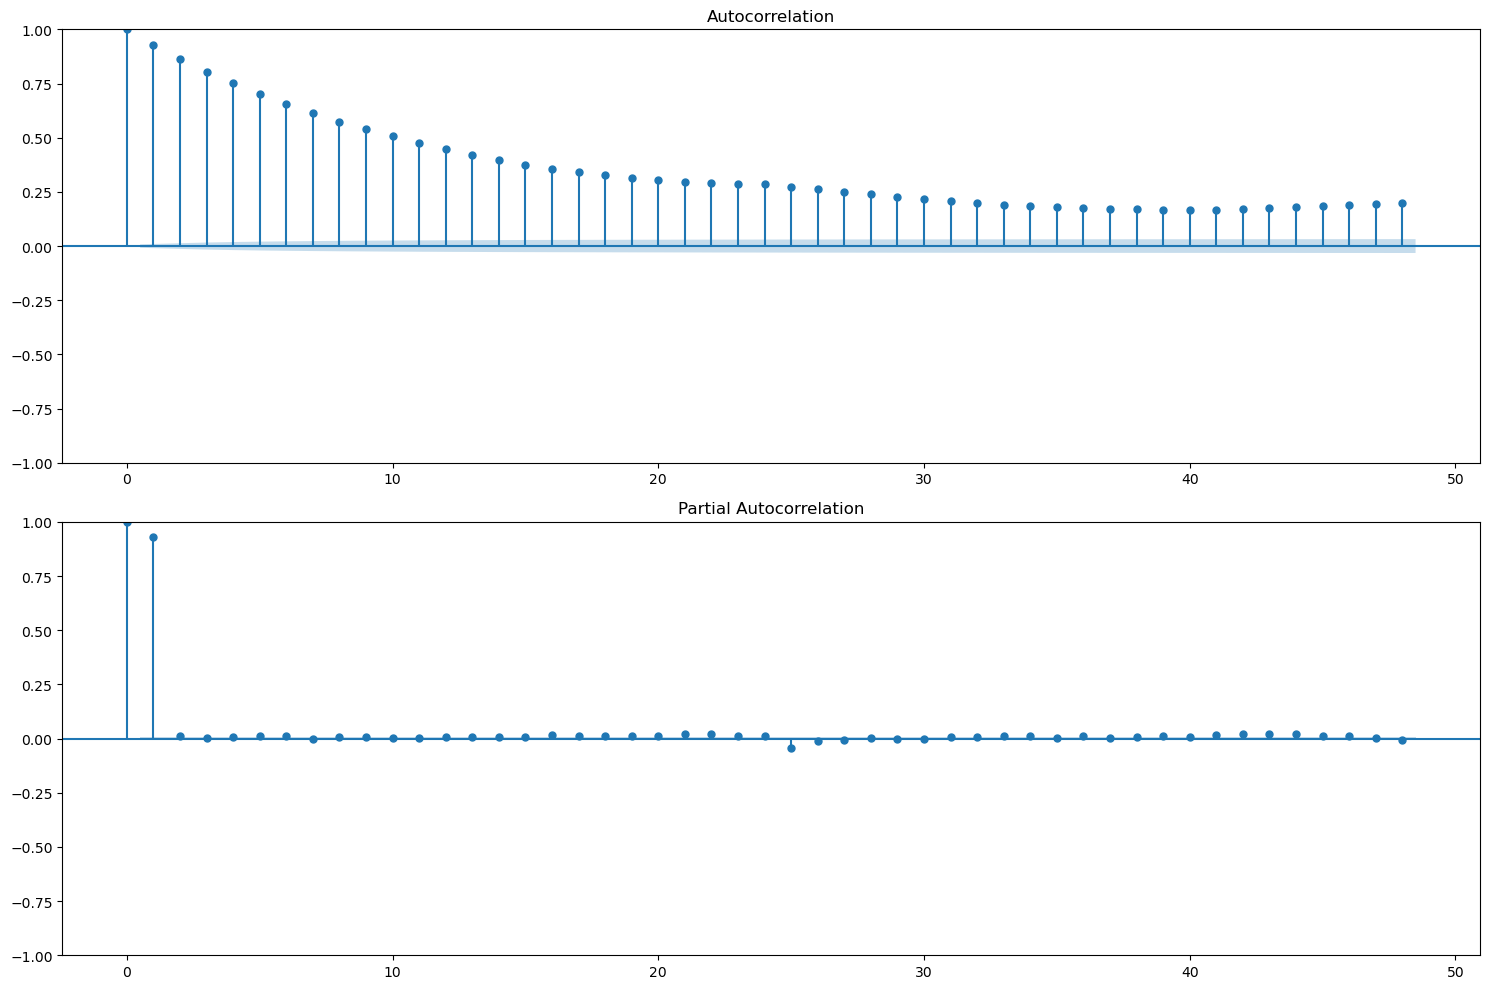

                                     SARIMAX Results                                      
Dep. Variable:                            SACTMIN   No. Observations:                61289
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -186696.186
Date:                            Thu, 27 Mar 2025   AIC                         373402.371
Time:                                    15:35:50   BIC                         373447.486
Sample:                                01-01-2015   HQIC                        373416.371
                                     - 12-28-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9185      0.002    576.448      0.000       0.915       0.922
ma.L1         -0.9973      0.000  -

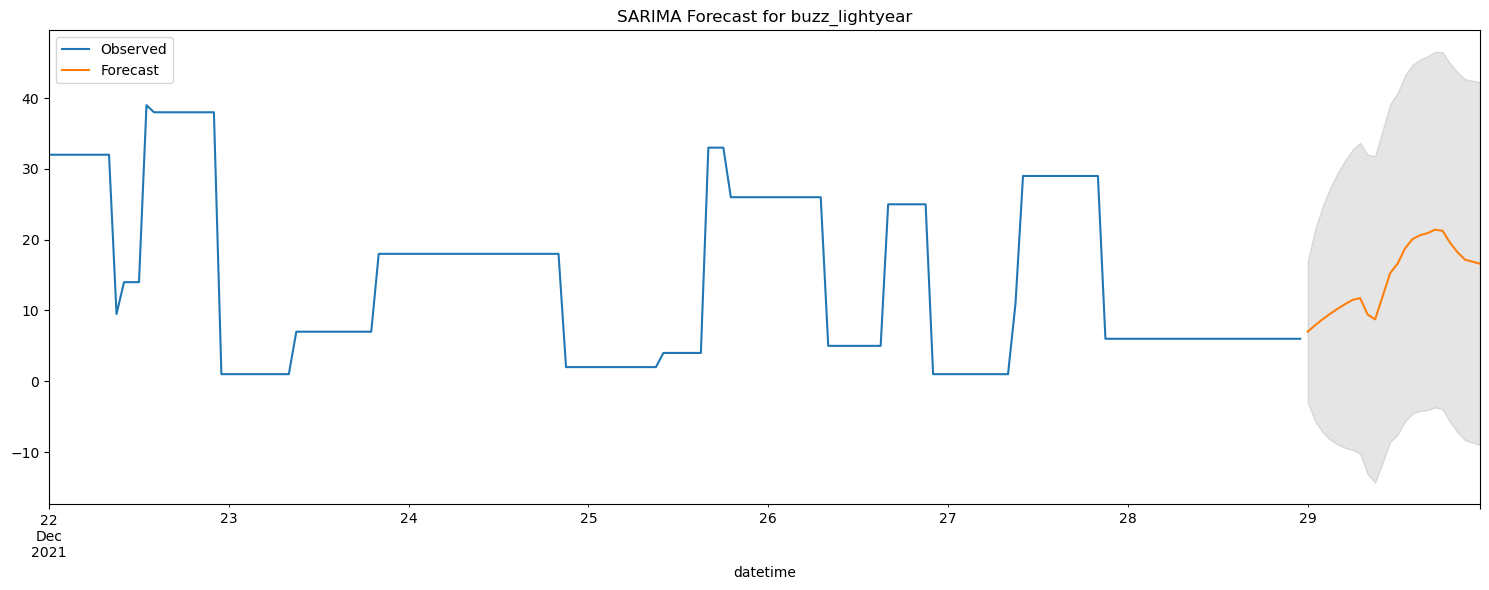

In [11]:
# Step 5: Time Series Approach for a single attraction
# Let's pick one popular attraction for time series analysis
popular_attraction = df_wait["attraction"].value_counts().index[0]
ts_data = df_wait[df_wait["attraction"] == popular_attraction].copy()
ts_data = ts_data.sort_values("datetime")

print(f"Time series analysis for attraction: {popular_attraction}")
print(f"Number of records: {len(ts_data)}")

# Resample to hourly data to create a proper time series
ts_data.set_index("datetime", inplace=True)
hourly_data = ts_data["SACTMIN"].resample("H").mean()

# Fill missing values with forward fill then backward fill
hourly_data = hourly_data.fillna(method="ffill").fillna(method="bfill")

# Plot the time series
plt.figure(figsize=(15, 6))
hourly_data.plot()
plt.title(f"Hourly Average Waiting Time for {popular_attraction}")
plt.xlabel("Date")
plt.ylabel("Waiting Time (minutes)")
plt.tight_layout()
plt.show()

# Create lagged features for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF to identify potential ARIMA parameters
plt.figure(figsize=(15, 10))
plt.subplot(211)
plot_acf(hourly_data.dropna(), ax=plt.gca(), lags=48)
plt.subplot(212)
plot_pacf(hourly_data.dropna(), ax=plt.gca(), lags=48)
plt.tight_layout()
plt.show()

# Fit SARIMA model
# Based on ACF/PACF analysis and the nature of theme park data (seasonal patterns)
# We'll try a model with daily seasonality (24 hours)
try:
    sarima_model = SARIMAX(
        hourly_data,
        order=(1, 1, 1),  # Non-seasonal ARIMA components (p,d,q)
        seasonal_order=(1, 1, 1, 24),  # Seasonal ARIMA components (P,D,Q,s)
    )
    sarima_results = sarima_model.fit(disp=False)
    print(sarima_results.summary())

    # Make predictions for next 24 hours
    forecast = sarima_results.get_forecast(steps=24)
    forecast_ci = forecast.conf_int()

    # Plot the forecast
    plt.figure(figsize=(15, 6))
    ax = hourly_data[-7 * 24 :].plot(label="Observed")
    forecast.predicted_mean.plot(ax=ax, label="Forecast")
    ax.fill_between(
        forecast_ci.index,
        forecast_ci.iloc[:, 0],
        forecast_ci.iloc[:, 1],
        color="k",
        alpha=0.1,
    )
    plt.title(f"SARIMA Forecast for {popular_attraction}")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error fitting SARIMA model: {e}")
    print("This might be due to non-stationarity or other issues with the time series.")
    print(
        "In a real application, we would need to implement more robust preprocessing."
    )


Finally, let's provide some final recommendations:

In [12]:
# Step 6: Final recommendations and conclusion
print("""
Model Performance Summary and Recommendations:

1. Random Forest Model:
   - Random Forest provides good baseline performance and handles the non-linear relationships in waiting time data
   - Feature importance shows which factors most influence waiting times
   - Advantages: Robust to outliers, captures complex relationships, provides feature importance

2. Gradient Boosting Models (XGBoost/LightGBM):
   - These models often outperform Random Forest for this type of regression task
   - They can capture more subtle patterns in the data
   - Advantages: Better performance, faster training (especially LightGBM)

3. Time Series Approach (SARIMA):
   - For accurate forecasting of individual attractions
   - Captures temporal patterns (daily/weekly seasonality)
   - Best for short-term predictions of specific attractions

Recommended Approach:
1. For general waiting time prediction across all attractions:
   - Use XGBoost or LightGBM with the features we created
   - Add more temporal features (holiday indicators, special events)

2. For specific attraction forecasting:
   - Use SARIMA or Prophet models for each individual attraction
   - These will capture the unique seasonal patterns of each ride

3. For production:
   - Consider ensemble methods combining the strengths of both approaches
   - Create separate models for weekends vs. weekdays
   - Update models regularly as patterns may change over time
""")



Model Performance Summary and Recommendations:

1. Random Forest Model:
   - Random Forest provides good baseline performance and handles the non-linear relationships in waiting time data
   - Feature importance shows which factors most influence waiting times
   - Advantages: Robust to outliers, captures complex relationships, provides feature importance

2. Gradient Boosting Models (XGBoost/LightGBM):
   - These models often outperform Random Forest for this type of regression task
   - They can capture more subtle patterns in the data
   - Advantages: Better performance, faster training (especially LightGBM)

3. Time Series Approach (SARIMA):
   - For accurate forecasting of individual attractions
   - Captures temporal patterns (daily/weekly seasonality)
   - Best for short-term predictions of specific attractions

Recommended Approach:
1. For general waiting time prediction across all attractions:
   - Use XGBoost or LightGBM with the features we created
   - Add more temporal fe